# 20231023_Lung_Xenium_marker_gene_analysis2

In [ ]:
import stlearn as st
import scanpy as sc
import numpy as np
import pandas as pd
import squidpy as sq
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from seaborn.matrix import _HeatMapper
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from six import StringIO
#from seaborn.external.six import string_types
from six import string_types

from seaborn.utils import despine, axis_ticklabels_overlap, relative_luminance, to_utf8

class _ScatterMapper(_HeatMapper):
    """
    Draw a scattermap plot, similar to heatmap plot, but use scatter dots instead of heatmap
    """

    def __init__(self, data,
                 marker, marker_size,
                 vmin, vmax, cmap, center, robust, cbar, cbar_kws,
                 xticklabels=True, yticklabels=True, mask=None):

        super(_ScatterMapper, self).__init__(
            data, vmin, vmax, cmap, center, robust, cbar=cbar, cbar_kws=cbar_kws,
            xticklabels=xticklabels, yticklabels=yticklabels, mask=mask,
            # Don't support annotation
            annot=False, fmt=None, annot_kws=None,
        )

        self.marker = marker

        if isinstance(marker_size, float) or isinstance(marker_size, int):
            self.marker_size = marker_size
        elif isinstance(marker_size, pd.DataFrame):
            self.marker_size = marker_size.loc[self.data.index, self.data.columns].values
        else:
            self.marker_size = marker_size
        
    def plot(self, ax, cax, kws):
        """Draw the scattermap on the provided Axes."""
        # Remove all the Axes spines
        despine(ax=ax, left=True, bottom=True)

        # Draw the heatmap
        data = self.plot_data

        range_y = np.arange(data.shape[0], dtype=int) + 0.5
        range_x = np.arange(data.shape[1], dtype=int) + 0.5
        x, y = np.meshgrid(range_x, range_y)

        hmap = ax.scatter(x, y,
                          c=data,
                          marker=self.marker,
                          cmap=self.cmap,
                          vmin=self.vmin, vmax=self.vmax,
                          s=self.marker_size, **kws)

        # Set the axis limits
        ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))

        # Possibly add a colorbar
        if self.cbar:
            cb = ax.figure.colorbar(hmap, cax, ax, **self.cbar_kws)
            cb.outline.set_linewidth(0)
            # If rasterized is passed to pcolormesh, also rasterize the
            # colorbar to avoid white lines on the PDF rendering
            if kws.get('rasterized', False):
                cb.solids.set_rasterized(True)

        # Add row and column labels
        if isinstance(self.xticks, string_types) and self.xticks == "auto":
            xticks, xticklabels = self._auto_ticks(ax, self.xticklabels, 0)
        else:
            xticks, xticklabels = self.xticks, self.xticklabels

        if isinstance(self.yticks, string_types) and self.yticks == "auto":
            yticks, yticklabels = self._auto_ticks(ax, self.yticklabels, 1)
        else:
            yticks, yticklabels = self.yticks, self.yticklabels

        ax.set(xticks=xticks, yticks=yticks)
        xtl = ax.set_xticklabels(xticklabels)
        ytl = ax.set_yticklabels(yticklabels, rotation="vertical")

        # Possibly rotate them if they overlap
        ax.figure.draw(ax.figure.canvas.get_renderer())
        if axis_ticklabels_overlap(xtl):
            plt.setp(xtl, rotation="vertical")
        if axis_ticklabels_overlap(ytl):
            plt.setp(ytl, rotation="horizontal")

        # Add the axis labels
        ax.set(xlabel=self.xlabel, ylabel=self.ylabel)

        # Annotate the cells with the formatted values
        if self.annot:
            self._annotate_heatmap(ax, hmap)

        # Invert the y axis to show the plot in matrix form
        ax.invert_yaxis()

def scattermap(data,
               marker='o',
               marker_size=100,
               vmin=None, vmax=None, cmap=None, center=None, robust=False,
               linewidths=0, linecolor="white",
               cbar=True, cbar_kws=None, cbar_ax=None,
               square=False, xticklabels="auto", yticklabels="auto",
               mask=None, ax=None, **kwargs):
    """Plot rectangular data as a color-encoded matrix.
    This function is similar to `sns.heatmap`, as it is an Axes-level function that will draw the
    heatmap into the currently-active Axes if none is provided to the ``ax`` argument.
    The main difference is that instead of drawing an actual heatmap with filled squares,
    this function will use the `plt.scatter` behind the scenes to draw a scatterplot-heatmap.
    The default is set to plot a grid of circles, however this can be changed via `marker`
    parameter.
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    marker: string, optional
        Marker to use: any marker that `pyplot.scatter` supports. Defaults to circle.
    marker_size: int or rectangular dataset
        Either an integer to set the marker size of all data points to,
        or a 2D dataset (like in `data`) that sets individual point sizes.
        Defaults to 100.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise they are inferred from the
        data and other keyword arguments.
    cmap : matplotlib colormap name or object, or list of colors, optional
        The mapping from data values to color space. If not provided, the
        default will depend on whether ``center`` is set.
    center : float, optional
        The value at which to center the colormap when plotting divergant data.
        Using this parameter will change the default ``cmap`` if none is
        specified.
    robust : bool, optional
        If True and ``vmin`` or ``vmax`` are absent, the colormap range is
        computed with robust quantiles instead of the extreme values.
    linewidths : float, optional
        Width of the border lines that will surround the markers
    linecolor : color, optional
        Color of the border lines to the markers
    cbar : boolean, optional
        Whether to draw a colorbar.
    cbar_kws : dict of key, value mappings, optional
        Keyword arguments for `fig.colorbar`.
    cbar_ax : matplotlib Axes, optional
        Axes in which to draw the colorbar, otherwise take space from the
        main Axes.
    square : boolean, optional
        If True, set the Axes aspect to "equal" so each cell will be
        square-shaped.
    xticklabels, yticklabels : "auto", bool, list-like, or int, optional
        If True, plot the column names of the dataframe. If False, don't plot
        the column names. If list-like, plot these alternate labels as the
        xticklabels. If an integer, use the column names but plot only every
        n label. If "auto", try to densely plot non-overlapping labels.
    mask : boolean array or DataFrame, optional
        If passed, data will not be shown in cells where ``mask`` is True.
        Cells with missing values are automatically masked.
    ax : matplotlib Axes, optional
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to ``ax.pcolormesh``.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the heatmap.
    See also
    --------
    clustermap : Plot a matrix using hierachical clustering to arrange the
                 rows and columns.
    Examples
    --------
    Plot a scattermap for a numpy array:
    .. plot::
        :context: close-figs
        >>> import numpy as np; np.random.seed(0)
        >>> import seaborn as sns; sns.set()
        >>> uniform_data = np.random.rand(10, 12)
        >>> ax = scattermap(uniform_data)
    Draw on white axes
    .. plot::
        :context: close-figs
        >>> uniform_data = np.random.rand(10, 12)
        >>> with sns.axes_style("white"):
        ...     ax = scattermap(uniform_data)
    Change the limits of the scattermap:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(uniform_data, vmin=0, vmax=1)
    Plot a scattermap for data centered on 0 with a diverging colormap:
    .. plot::
        :context: close-figs
        >>> normal_data = np.random.randn(10, 12)
        >>> ax = scattermap(normal_data, center=0)
    Plot a dataframe with meaningful row and column labels:
    .. plot::
        :context: close-figs
        >>> flights = sns.load_dataset("flights")
        >>> flights = flights.pivot("month", "year", "passengers")
        >>> ax = scattermap(flights)
    Add border lines around each glyph:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, linewidths=1, linecolor='black')
    Use a different colormap:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, cmap="YlGnBu")
    Center the colormap at a specific value:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, center=flights.loc["January", 1955])
    Plot every other column label and don't plot row labels:
    .. plot::
        :context: close-figs
        >>> data = np.random.randn(50, 20)
        >>> ax = scattermap(data, xticklabels=2, yticklabels=False)
    Don't draw a colorbar:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, cbar=False)
    Use different axes for the colorbar:
    .. plot::
        :context: close-figs
        >>> grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
        >>> f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
        >>> ax = scattermap(flights, ax=ax,
        ...                  cbar_ax=cbar_ax,
        ...                  cbar_kws={"orientation": "horizontal"})
    Use a mask to plot only part of a matrix
    .. plot::
        :context: close-figs
        >>> corr = np.corrcoef(np.random.randn(10, 200))
        >>> mask = np.zeros_like(corr)
        >>> mask[np.triu_indices_from(mask)] = True
        >>> with sns.axes_style("white"):
        ...     ax = scattermap(corr, mask=mask, vmax=.3, square=True)
     Change glyph, plot stars instead of circles
    .. plot::
        :context: close-figs
        >>> ax = scattermap(corr, vmax=.3, square=True, marker='*')
    Plot multiple markers on the same plot
    >>> corr = np.corrcoef(np.random.randn(10, 200))
    >>> mask = np.zeros_like(corr)
    >>> mask[np.triu_indices_from(mask)] = True
    >>> with sns.axes_style("white"):
    ...     ax = scattermap(corr, mask=mask, vmax=.3, square=True)
    ...     ax = scattermap(corr, mask=mask.T, vmax=.3, square=True, ax=ax, marker='*', cbar=False)
    Specify size for points
    .. plot::
        :context: close-figs
    >>> with sns.axes_style("white"):
    ...     ax = scattermap(corr, vmax=.3, square=True, marker_size=np.abs(corr)*300)
    """
    # Initialize the plotter object
    plotter = _ScatterMapper(data,
                             marker, marker_size,
                             vmin, vmax, cmap, center, robust,
                             cbar, cbar_kws, xticklabels,
                             yticklabels, mask)

    # Add the pcolormesh kwargs here
    kwargs["linewidths"] = linewidths
    kwargs["edgecolor"] = linecolor

    # Draw the plot and return the Axes
    if ax is None:
        ax = plt.gca()
    if square:
        ax.set_aspect("equal")
    plotter.plot(ax, cbar_ax, kwargs)
    return ax


## Lung panel

In [126]:
# load data of case 7 of lung panel
xenium_case7_post_lung_panel_path = "/Volumes/Project/home/sakai/scRNA/20230518_Xenium/DATA/Xenium_Outputs/output-XETG00053__0003973__SQUAT-Case7__20230502__074131/"
adata_xenium_case7_post_lung_panel = st.ReadXenium(
    feature_cell_matrix_file=f"{xenium_case7_post_lung_panel_path}cell_feature_matrix.h5",
    cell_summary_file=f"{xenium_case7_post_lung_panel_path}cells.csv.gz",
    library_id="Xenium_case7_post_lung_panel",
    image_path="/Volumes/Project/home/sakai/sample.jpg",
    scale=1,
    spot_diameter_fullres=15 # Recommend
)

# count table
df_xenium = adata_xenium_case7_post_lung_panel.to_df()

Added tissue image to the object!


In [128]:
"CXCR5" in df_xenium.columns.tolist()


True

### 1 plus

In [80]:
# LYM: CD3E, CD4, CD8A, GZMB
# Macro: CD14, CD19, MSR1
# DC: MS4A4A, ITGAX, HLA-DQB2
# ICI: CD274, CTLA4, IDO1, LAG3, TIGIT

cell_marker = [
    "CD3E", "CD4", "CD8A", "GZMB", # LYM
    "CD19", "MSR1", "CD68", "CD163", # Macro
    "MS4A4A", "ITGAX", "HLA-DQB2", # DC
    "KRT8", "CDH1", # tumor
    "CD274", "CTLA4", "IDO1", "LAG3", "TIGIT" # ICI
]


In [81]:
# mean
res_ls = []

for i in cell_marker:
    temp_ls  = []

    # CXCL13+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1)])]

    # CXCL9+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=cell_marker, 
    columns=["CXCL13+", "CXCL9+"]
)

# count
res_ls = []

for i in cell_marker:
    temp_ls  = []
    # CXCL13+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1)][i].mean()]

    # CXCL9+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=cell_marker, 
    columns=["CXCL13+", "CXCL9+"]
)

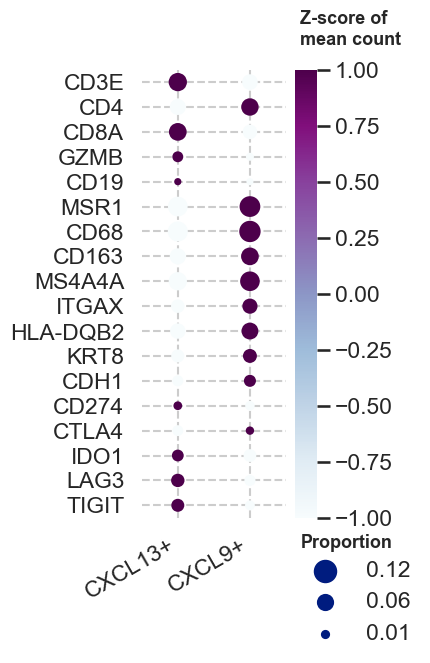

In [82]:
# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(4.3, 7))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(2.2, 19.2, "Proportion", rotation=360, fontsize=13, weight="bold")
ax.text(2.2, -1., "Z-score of \nmean count", rotation=360, fontsize=13, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231023_bubble_chart_case7_after_1plus.png", dpi=500)

### 2 plus

In [83]:
# mean
res_ls = []

for i in cell_marker:
    temp_ls  = []

    # CXCL13+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2)])]

    # CXCL9+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=cell_marker, 
    columns=["CXCL13+", "CXCL9+"]
)

# count
res_ls = []

for i in cell_marker:
    temp_ls  = []
    # CXCL13+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2)][i].mean()]

    # CXCL9+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=cell_marker, 
    columns=["CXCL13+", "CXCL9+"]
)

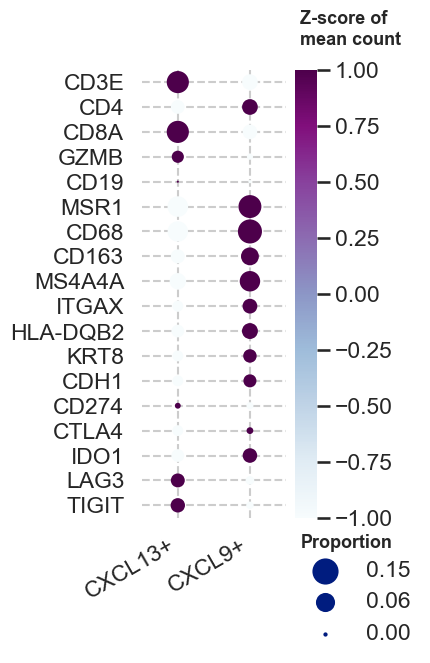

In [84]:
# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(4.3, 7))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(2.2, 19.2, "Proportion", rotation=360, fontsize=13, weight="bold")
ax.text(2.2, -1., "Z-score of \nmean count", rotation=360, fontsize=13, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231023_bubble_chart_case7_after_2plus.png", dpi=500)

## immune panel

In [86]:
# load data of case 7 of immune panel
xenium_case7_post_immune_panel_path = "/Volumes/Project/home/sakai/scRNA/20230518_Xenium/DATA/Xenium_Outputs/20230821__074259__2_019/Xenium_Outputs/output-XETG00053__0006778__15_NSCLC_Case7__20230821__075703/"
adata_xenium_case7_post_immune_panel = st.ReadXenium(
    feature_cell_matrix_file=f"{xenium_case7_post_immune_panel_path}cell_feature_matrix.h5",
    cell_summary_file=f"{xenium_case7_post_immune_panel_path}cells.csv.gz",
    library_id="Xenium_case7_post_lung_panel",
    image_path="/Volumes/Project/home/sakai/sample.jpg",
    scale=1,
    spot_diameter_fullres=15 # Recommend
)

df_xenium = adata_xenium_case7_post_immune_panel.to_df()

Added tissue image to the object!


In [87]:
receptor_marker = [
    "CCR1", "CCR2", "CCR3", "CCR4", "CCR6", "CCR7", "CCR8", 
    "CXCR2", "CXCR3", "CXCR4", "CXCR6", 
    "IL10RB", "IL12RB1", "IL23R", "IL3RA", "IL6R", "IL7R", 
    "IFNAR1", "IFNAR2", "IFNGR1", "IFNGR2", "IFNLR1" 
]

humoral_marker = [
    "CCL2", "CCL3", "CCL3L1", "CCL5", "CCL18", "CCL20", "CCL28", 
    "CXCL5", "CXCL8", "CXCL9", "CXCL10", "CXCL12", "CXCL13", "CXCL14", "CXCL16", "IFNG", 
    "IL1A", "IL1B", "IL6", "IL7", "IL10", "IL12A", "IL12B", "IL18", "IL23A", "IL24", "IL33", "IL34"
]

regulator_marker =[
    "TLR2", "TLR3", "TLR4", "TLR9", "TMEM173",
    "CGAS", "DDX41", "DDX58", "IFIH1", "MAVS", 
    "IRF1", "IRF2", "IRF3", "IRF4", "IRF5", "IRF7", "IRF9", 
    "NFKB1", "NFKB2", "STAT1", "STAT5B", "HIF1A", "CIITA", "CTNNB1", 
]

In [120]:
for i in regulator_marker:
    print(i, end=", ")

TLR2, TLR4, TMEM173, CGAS, DDX58, IRF1, IRF9, NFKB1, STAT1, CIITA, 

### 1 plus

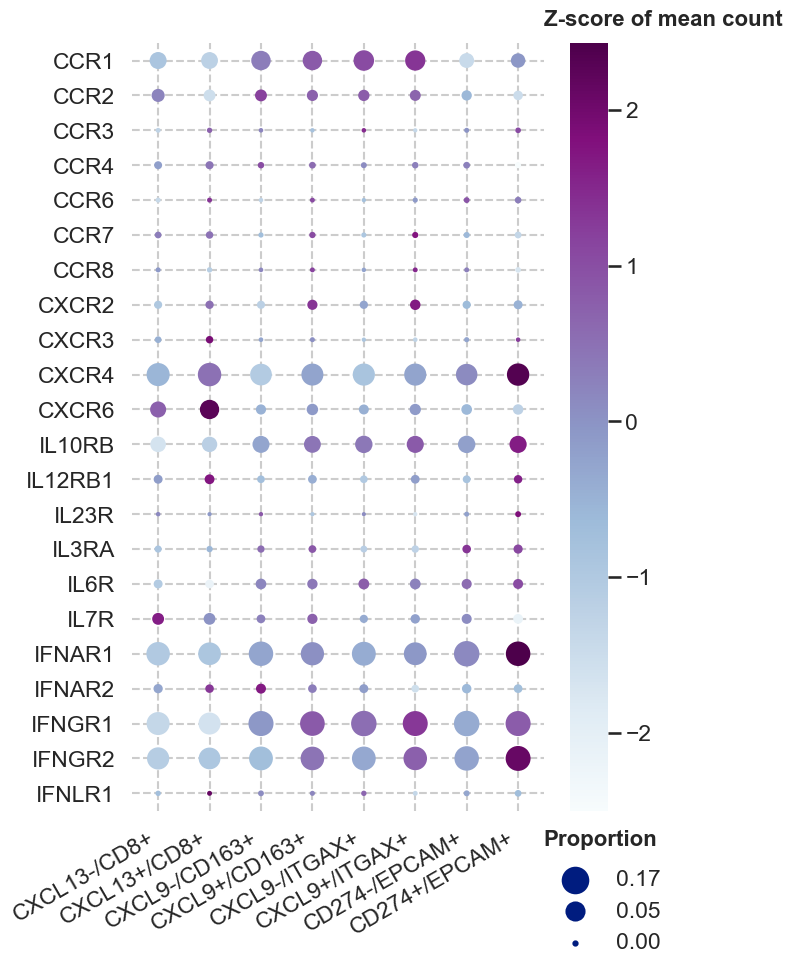

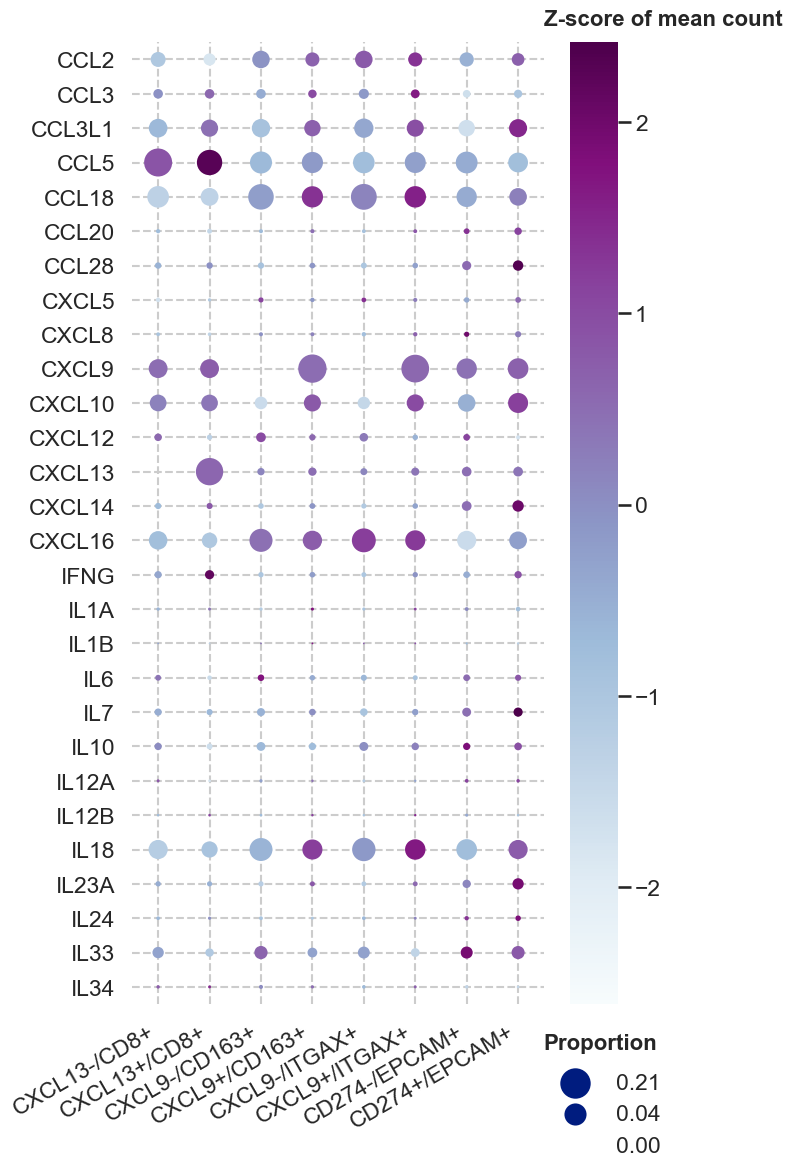

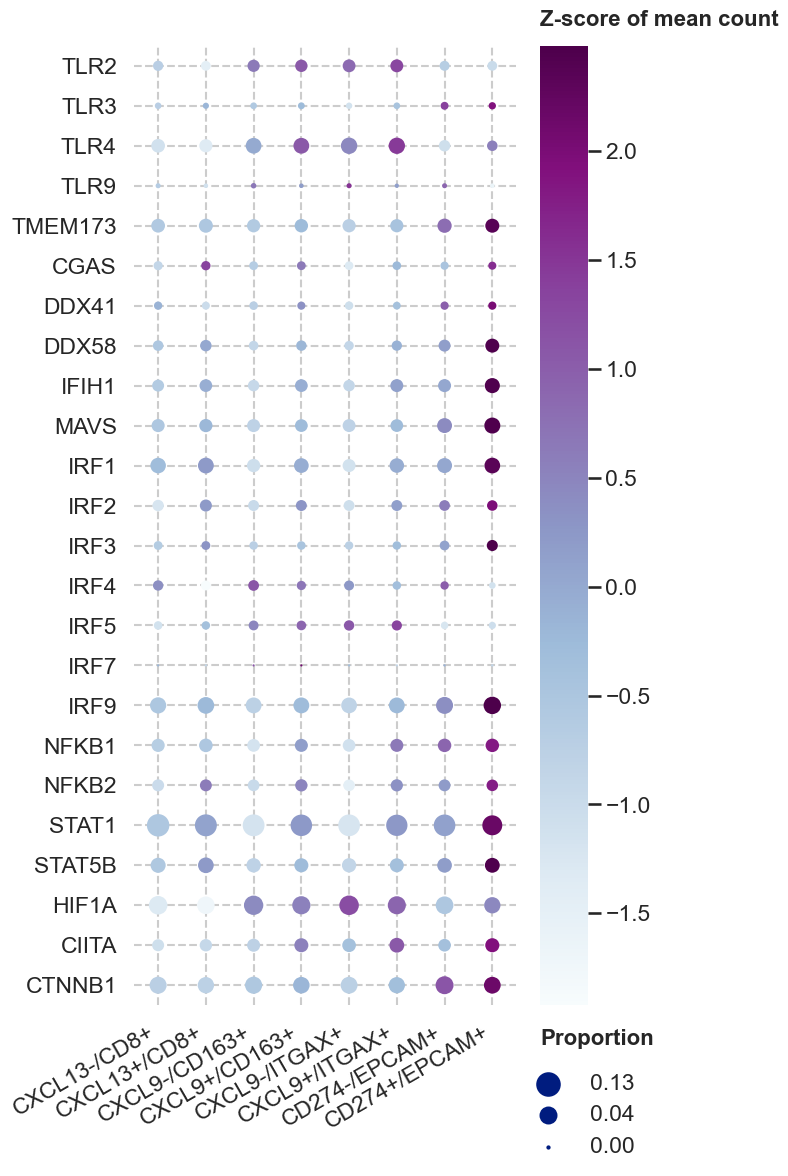

In [104]:
# count
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 1)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD163"] >= 1)][i].mean()]

    # CXCL9- ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 1)][i].mean()]

    # CXCL9+ ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["ITGAX"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD163"] >= 1)])]

    # CXCL9- ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 1)])]

    # CXCL9+ ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["ITGAX"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 10))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8, 23, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("20231023_bubble_chart_receptor_case7_after_1_plus.png", dpi=500)

# count
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 1)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD163"] >= 1)][i].mean()]

    # CXCL9- ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 1)][i].mean()]

    # CXCL9+ ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["ITGAX"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD163"] >= 1)])]

    # CXCL9- ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 1)])]

    # CXCL9+ ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["ITGAX"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 12))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8, 29.3, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231023_bubble_chart_humoral_case7_after_1_plus.png", dpi=500)

# count
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 1)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD163"] >= 1)][i].mean()]

    # CXCL9- ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 1)][i].mean()]

    # CXCL9+ ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["ITGAX"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD163"] >= 1)])]

    # CXCL9- ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 1)])]

    # CXCL9+ ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["ITGAX"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 12))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8.5, 25, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8.5, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231023_bubble_chart_regulator_case7_after_1_plus.png", dpi=500)

### 2 plus

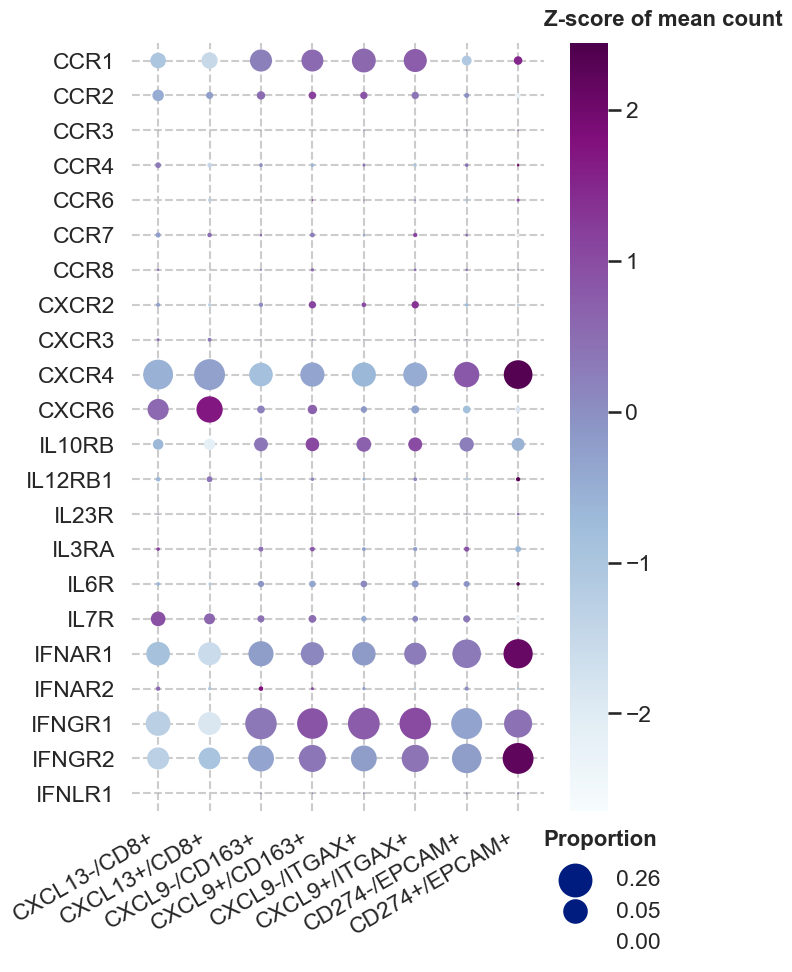

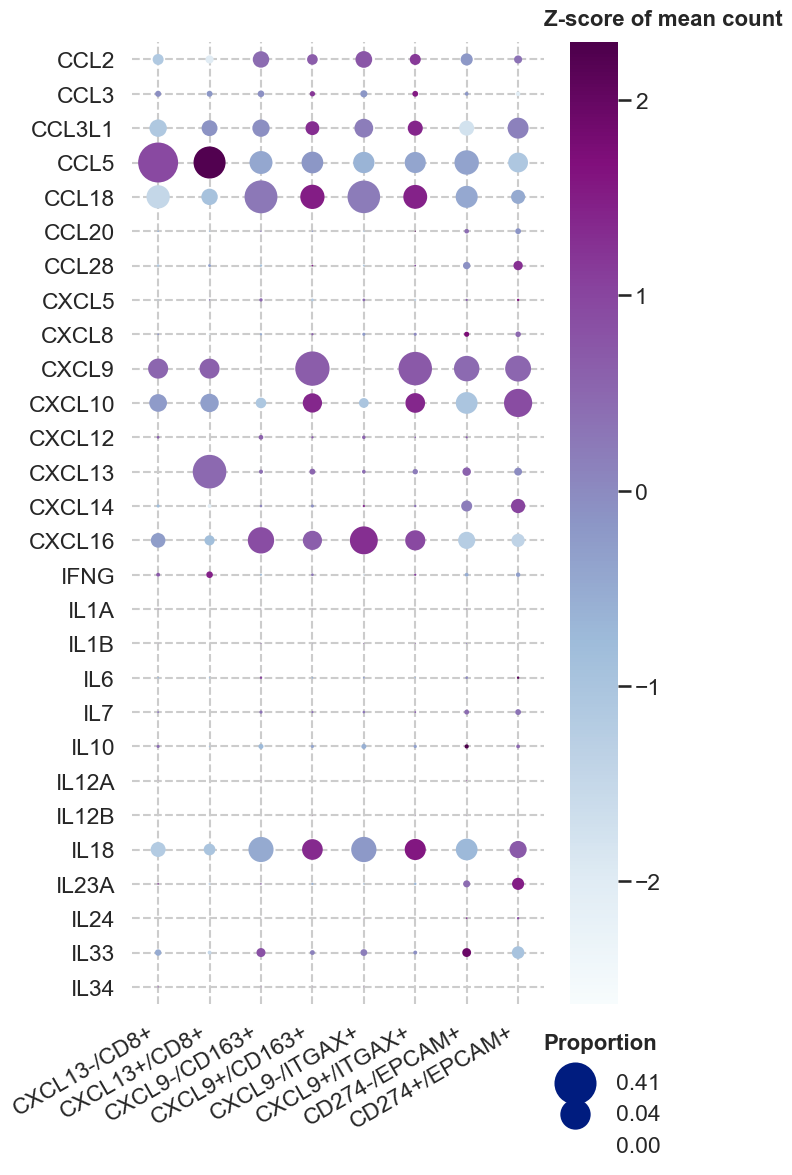

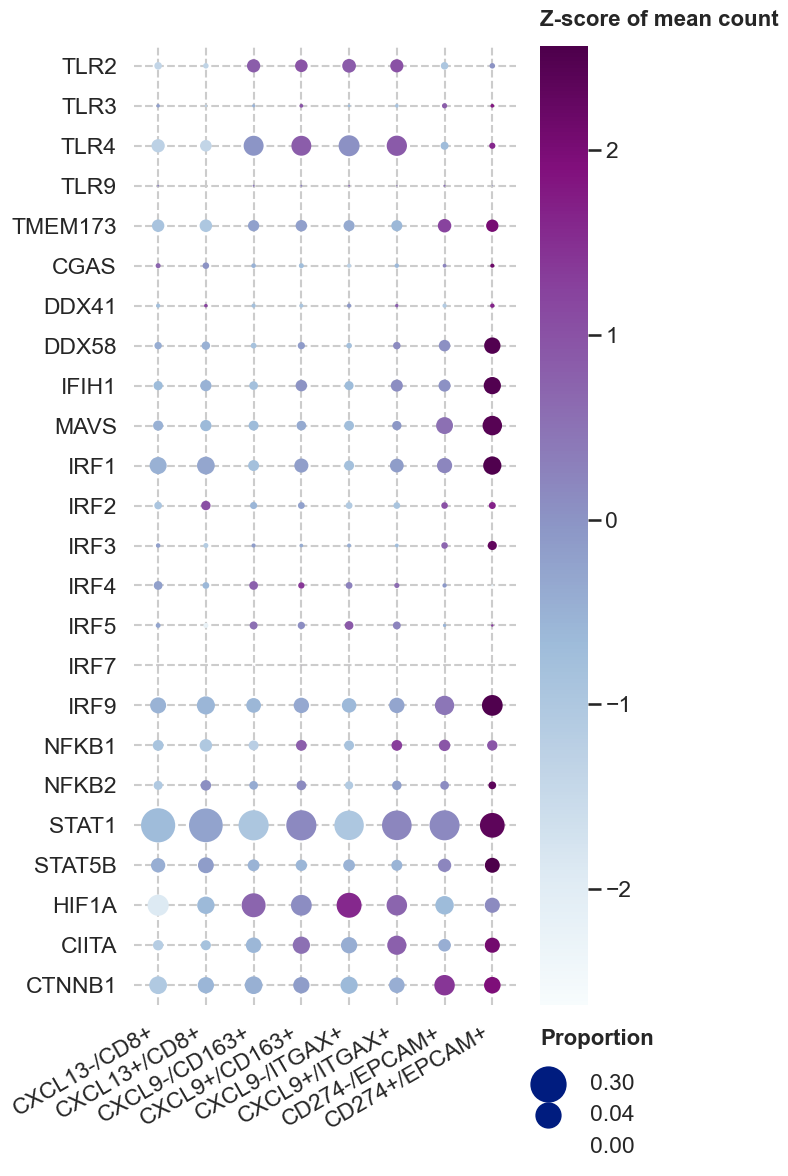

In [105]:
# count
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 2)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2) & (df_xenium["CD8A"] >= 2)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 2)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["CD163"] >= 2)][i].mean()]

    # CXCL9- ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 2)][i].mean()]

    # CXCL9+ ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["ITGAX"] >= 2)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] >= 2)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 2)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2) & (df_xenium["CD8A"] >= 2)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 2)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["CD163"] >= 2)])]

    # CXCL9- ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 2)])]

    # CXCL9+ ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["ITGAX"] >= 2)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] >= 2)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 10))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8, 23, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("20231023_bubble_chart_receptor_case7_after_2_plus.png", dpi=500)

# count
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 2)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2) & (df_xenium["CD8A"] >= 2)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 2)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["CD163"] >= 2)][i].mean()]

    # CXCL9- ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 2)][i].mean()]

    # CXCL9+ ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["ITGAX"] >= 2)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] >= 2)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 2)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2) & (df_xenium["CD8A"] >= 2)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 2)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["CD163"] >= 2)])]

    # CXCL9- ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 2)])]

    # CXCL9+ ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["ITGAX"] >= 2)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] >= 2)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 12))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8, 29.3, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231023_bubble_chart_humoral_case7_after_2_plus.png", dpi=500)

# count
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 2)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2) & (df_xenium["CD8A"] >= 2)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 2)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["CD163"] >= 2)][i].mean()]

    # CXCL9- ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 2)][i].mean()]

    # CXCL9+ ITGAX+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["ITGAX"] >= 2)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] >= 2)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 2)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL13"] >= 2) & (df_xenium["CD8A"] >= 2)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD163"] >= 2)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["CD163"] >= 2)])]

    # CXCL9- ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] == 0) & (df_xenium["ITGAX"] >= 2)])]

    # CXCL9+ ITGAX+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["CXCL9"] >= 2) & (df_xenium["ITGAX"] >= 2)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 2) & (df_xenium["EPCAM"] >= 2) & (df_xenium["CD274"] >= 2)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD163+", "CXCL9+/CD163+", "CXCL9-/ITGAX+", "CXCL9+/ITGAX+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 12))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8.5, 25, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8.5, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231023_bubble_chart_regulator_case7_after_2_plus.png", dpi=500)

## Immune panel version 2

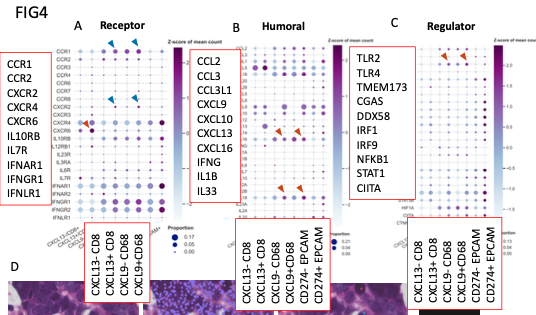

In [ ]:
# load data of case 7 of immune panel
xenium_case7_post_immune_panel_path = "/Volumes/Project/home/sakai/scRNA/20230518_Xenium/DATA/Xenium_Outputs/20230821__074259__2_019/Xenium_Outputs/output-XETG00053__0006778__15_NSCLC_Case7__20230821__075703/"
adata_xenium_case7_post_immune_panel = st.ReadXenium(
    feature_cell_matrix_file=f"{xenium_case7_post_immune_panel_path}cell_feature_matrix.h5",
    cell_summary_file=f"{xenium_case7_post_immune_panel_path}cells.csv.gz",
    library_id="Xenium_case7_post_lung_panel",
    image_path="/Volumes/Project/home/sakai/sample.jpg",
    scale=1,
    spot_diameter_fullres=15 # Recommend
)

df_xenium = adata_xenium_case7_post_immune_panel.to_df()

In [117]:
receptor_marker = [
    "CCR1", "CCR2", 
    "CXCR2", "CXCR3",
    "CXCR6", 
    "IL10RB", "IL7R", 
    "IFNGR1", "IFNGR2", #"IFNLR1" 
]

humoral_marker = [
    "CCL2", "CCL3", "CCL3L1", 
    "CXCL9", "CXCL10", "CXCL13", "CXCL16", "IFNG", 
    "IL18", "IL33"
]

regulator_marker =[
    "TLR2", "TLR4", "TMEM173",
    "CGAS", "DDX58", 
    "IRF1", "IRF9", 
    "NFKB1", "STAT1", "CIITA"
]

### 1 plus

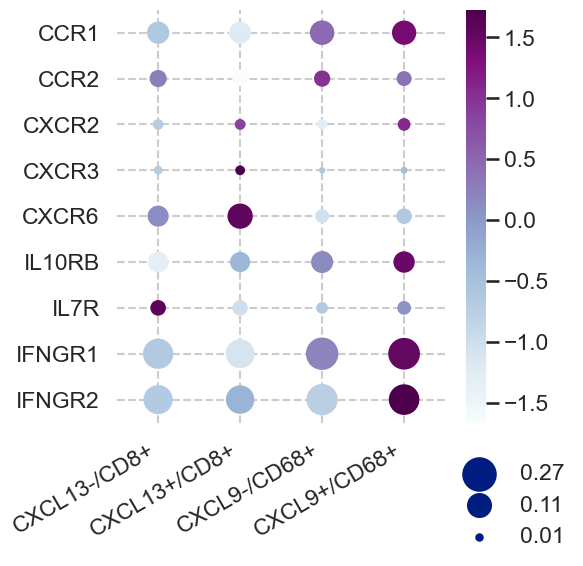

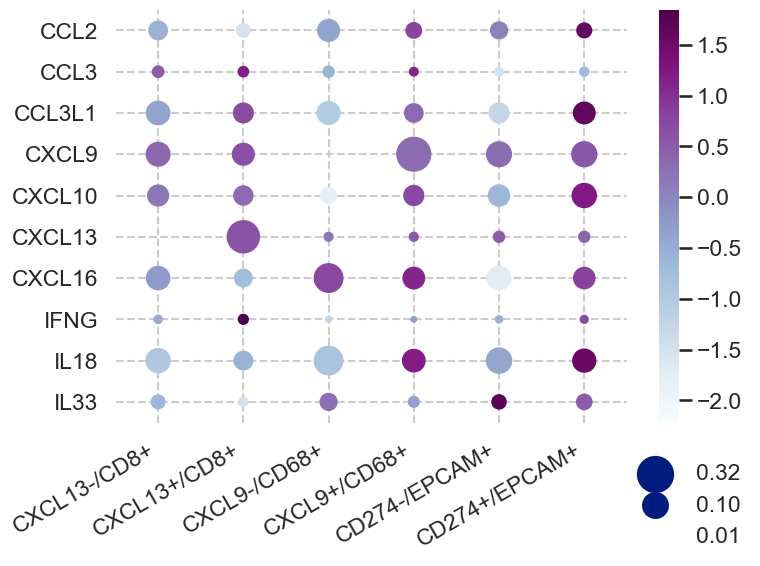

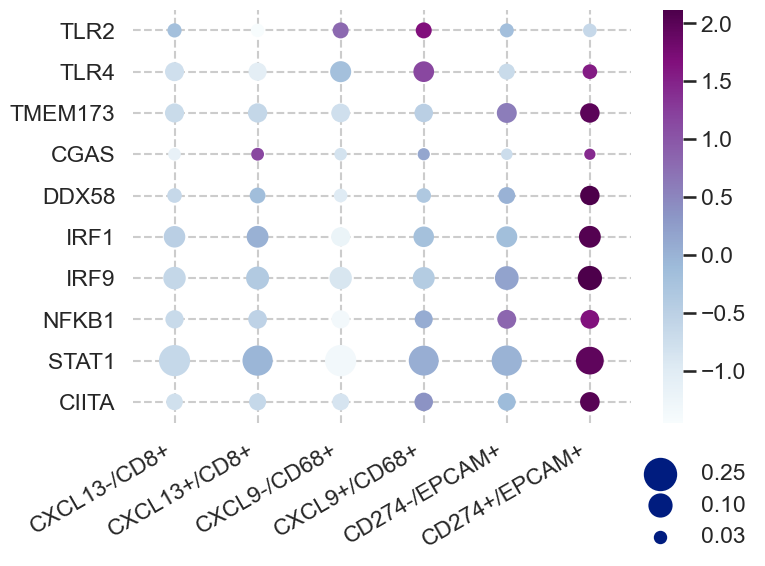

In [118]:
# count
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)][i].mean()]

    # CXCL9+ CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
    ]
)

# mean
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(6, 6))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
#ax.text(8, 23, "Proportion", rotation=360, fontsize=16, weight="bold")
#ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("20231025_bubble_chart_receptor_case7_after_1_plus.png", dpi=500)

# count
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 6))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
#ax.text(8, 29.3, "Proportion", rotation=360, fontsize=16, weight="bold")
#ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231025_bubble_chart_humoral_case7_after_1_plus.png", dpi=500)

# count
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)][i].mean()]

    # CXCL9+ CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD68+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)])]

    # CXCL9+ CD68+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 6))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
#ax.text(8.5, 25, "Proportion", rotation=360, fontsize=16, weight="bold")
#ax.text(8.5, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231025_bubble_chart_regulator_case7_after_1_plus.png", dpi=500)

## immune panel version 2 (all gene)

In [123]:
receptor_marker = [
    "CCR1", "CCR2", "CCR3", "CCR4", "CCR6", "CCR7", "CCR8", 
    "CXCR2", "CXCR3", "CXCR4", "CXCR6", 
    "IL10RB", "IL12RB1", "IL23R", "IL3RA", "IL6R", "IL7R", 
    "IFNAR1", "IFNAR2", "IFNGR1", "IFNGR2", "IFNLR1" 
]

humoral_marker = [
    "CCL2", "CCL3", "CCL3L1", "CCL5", "CCL18", "CCL20", "CCL28", 
    "CXCL5", "CXCL8", "CXCL9", "CXCL10", "CXCL12", "CXCL13", "CXCL14", "CXCL16", "IFNG", 
    "IL1A", "IL1B", "IL6", "IL7", "IL10", "IL12A", "IL12B", "IL18", "IL23A", "IL24", "IL33", "IL34"
]

regulator_marker =[
    "TLR2", "TLR3", "TLR4", "TLR9", "TMEM173",
    "CGAS", "DDX41", "DDX58", "IFIH1", "MAVS", 
    "IRF1", "IRF2", "IRF3", "IRF4", "IRF5", "IRF7", "IRF9", 
    "NFKB1", "NFKB2", "STAT1", "STAT5B", "HIF1A", "CIITA", "CTNNB1", 
]

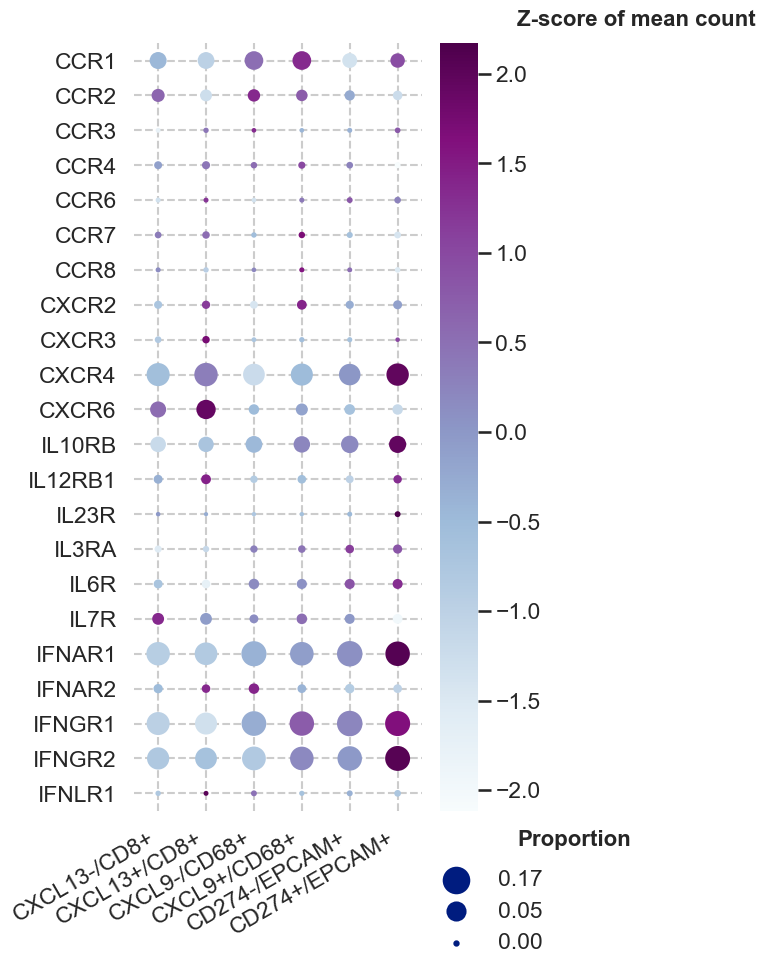

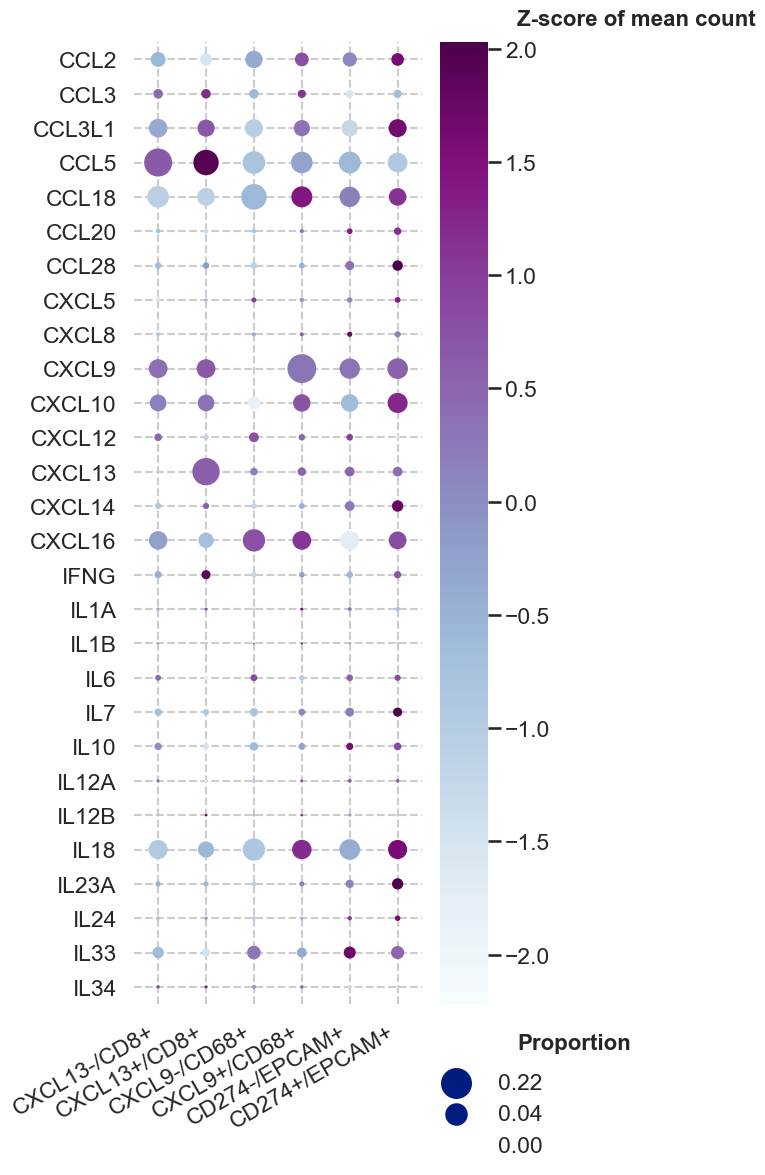

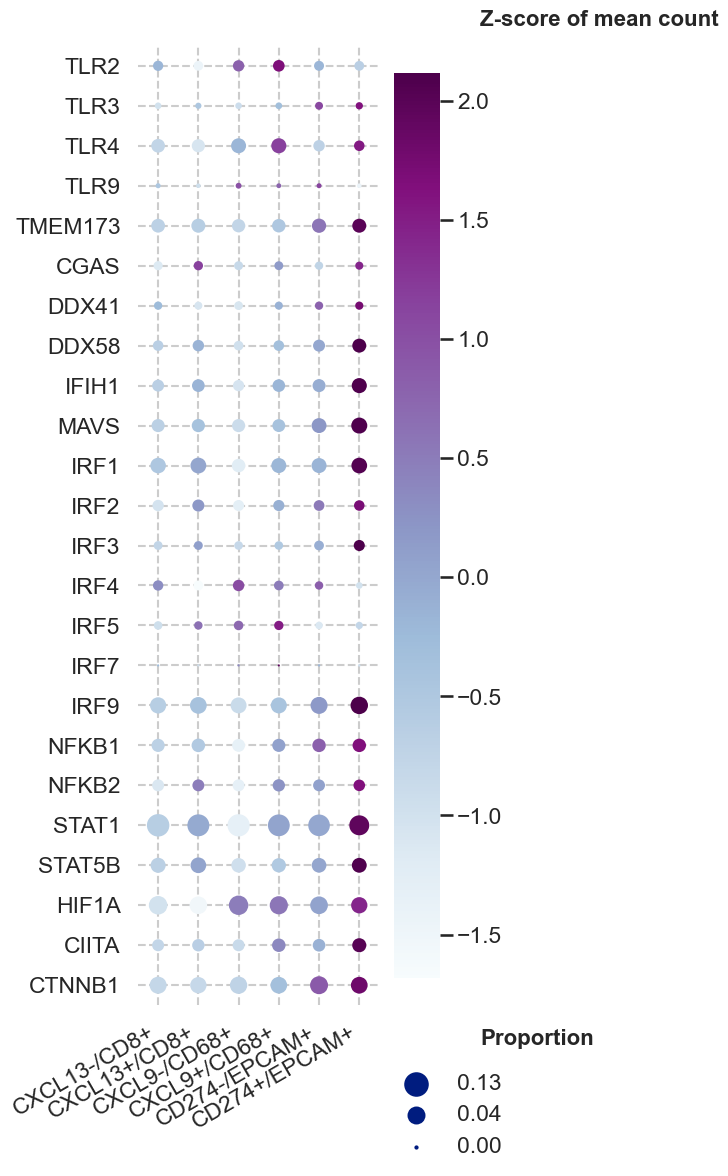

In [124]:
# count
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)][i].mean()]

    # CXCL9+ CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+" 
    ]
)

# mean
res_ls = []

for i in receptor_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=receptor_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 10))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8, 23, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("20231101_bubble_chart_receptor_case7_after_1_plus.png", dpi=500)


# count
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)][i].mean()]

    # CXCL9+ CD168+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in humoral_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)])]

    # CXCL9+ CD168+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=humoral_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 12))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8, 29.3, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231101_bubble_chart_humoral_case7_after_1_plus.png", dpi=500)

# count
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL13+ CD8+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)][i].mean()]

    # CXCL9- CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)][i].mean()]

    # CXCL9+ CD68+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)][i].mean()]

    # EPCAM+ CD274-
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)][i].mean()]

    # EPCAM+ CD274+
    temp_ls += [df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)][i].mean()]

    res_ls += [temp_ls]

df_res_mean = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# mean
res_ls = []

for i in regulator_marker:
    temp_ls  = []

    # CXCL13- CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] == 0) & (df_xenium["CD8A"] >= 1)])]

    # CXCL13+ CD8+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL13"] >= 1) & (df_xenium["CD8A"] >= 1)])]

    # CXCL9- CD68+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] == 0) & (df_xenium["CD68"] >= 1)])]

    # CXCL9+ CD68+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["CXCL9"] >= 1) & (df_xenium["CD68"] >= 1)])]

    # EPCAM+ CD274-
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] == 0)])]

    # EPCAM+ CD274+
    temp_ls += [len(df_xenium[(df_xenium[i] >= 1) & (df_xenium["EPCAM"] >= 1) & (df_xenium["CD274"] >= 1)])]

    res_ls += [temp_ls]

df_res_prop = pd.DataFrame(
    res_ls, 
    index=regulator_marker, 
    columns=[
        "CXCL13-/CD8+", "CXCL13+/CD8+", 
        "CXCL9-/CD68+", "CXCL9+/CD68+", 
        "CD274-/EPCAM+", "CD274+/EPCAM+"
    ]
)

# plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

fig = plt.figure(figsize=(8, 12))
ax = scattermap(
    df_res_mean.fillna(0).apply(lambda x: scipy.stats.zscore(np.log(x+1)), axis=1), 
    cmap="BuPu", marker_size=df_res_prop.fillna(0).apply(lambda x: x/sum(x)*2000, axis=0), 
)
plt.grid(True)

# Create a dot size legend using off-axis scatter calls and legend
mk_size_max = 2000  * np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0))
mk_size_min = 2000  * np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0))

ax.scatter(-1, -1, label=f"{np.amax(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max)
ax.scatter(-1, -1, label=f"{np.mean(df_res_prop.apply(lambda x: x/sum(x), axis=0)):0.2f}", marker="o", c="b", s=mk_size_max * 0.5)
ax.scatter(-1, -1, label=f"{np.amin(df_res_prop.apply(lambda x: x/sum(x), axis=0)[df_res_prop.apply(lambda x: x/sum(x), axis=0) != 0]):0.2f}", marker="o", c="b", s=mk_size_min)

ax.legend(loc="upper left", bbox_to_anchor=(0.97, -0.05), frameon=False)
ax.text(8.5, 25, "Proportion", rotation=360, fontsize=16, weight="bold")
ax.text(8.5, -0.5, "Z-score of mean count", rotation=360, fontsize=16, weight="bold")
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("20231101_bubble_chart_regulator_case7_after_1_plus.png", dpi=500)

In [125]:
df_xenium

,ACTG2,AGER,APC,ARG1,ATM,ATR,B2M,BAX,BCL6,BRAF,...,TP63,TP73,TRAF6,TTF1,VCAM1,VEGFA,VEGFB,VIL1,VWF,WT1
aaaaenih-1,0.0,1.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
aaaakmjm-1,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaabcgbj-1,2.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
aaabecbp-1,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaabphkn-1,2.0,1.0,0.0,0.0,3.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oiielgmm-1,0.0,1.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0
oiifaado-1,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
oiifadgd-1,5.0,0.0,0.0,0.0,2.0,1.0,26.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
oiifbdim-1,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
